In [1]:
## This is trained on other mis-spellings
# Similar to earlier one (the normal without v1)

In [2]:
import pandas as pd
import numpy as np  # linear algebra
import string
import re
import sys
import os

import jellyfish # library for fuzzy text comparisons

from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from tqdm import tqdm_pandas, tqdm_notebook as tqdm
from tqdm import tqdm as tqorig
tqorig.pandas(tqdm)

In [3]:
PATH_TO_GLOVE = './glove.840B.300d.txt' #840 billion word version

try:
    #sys.path.append(os.path.expanduser(PATH_TO_FAISS))
    import faiss
    FAISS_AVAILABLE = True
except:
    FAISS_AVAILABLE = False

print(FAISS_AVAILABLE)

True


In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

def get_all_glove(glove_path):
    # create word_vec with glove vectors
    glove_dict = {}
    with open(glove_path) as f:
        for line in tqdm(f):
            word, vec = line.split(' ', 1)
            glove_dict[word] = np.array(list(map(float, vec.split())), dtype=np.float32)
    return glove_dict

In [5]:
# Load the GloVe vectors into a dictionary. Takes ~8 minutes
glove = get_all_glove(PATH_TO_GLOVE) 

In [5]:
# Convert the dictionary to an embedding matrix, a dictionary mapping from word to id, and a list which will map from id to word
emb = np.zeros((len(glove), 300), dtype=np.float32) #NOte that these will be sorted according to the word frequency
w2id = {}
id2w=[]
for cc, word in enumerate(glove.keys()):
    emb[cc]=glove[word]
    w2id[word]=cc
    id2w.append(word)

#For faiss specifically
emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

In [6]:
if FAISS_AVAILABLE:
    d = emb.shape[1]    # 300
    # index = faiss.IndexFlatL2(d)
    index = faiss.IndexFlatIP(d)                # This creates the index
    index.add(emb)                              # This adds all the word vectors to the index
    print(index.ntotal, 'words now in index')

2196016 words now in index


In [7]:
def getNeighbours(word_list, transform_vector=0, c=1.0, neighbours=10, metric='cosine', use_faiss=FAISS_AVAILABLE):
    word_embeds = np.vstack([emb[w2id[x]] for x in word_list]) # create a numpy array of word embeddings
    if use_faiss:
        # Get neighbours
        distances, indices = index.search((word_embeds - transform_vector*c).astype(np.float32), neighbours)
    else:
        dist_matrix = cdist((word_embeds - transform_vector*c).astype(np.float32), emb, metric=metric)
        indices = np.argsort(dist_matrix)[:, :neighbours]
    return indices

# Converts indices to words.
def toWords(index_list, n=10):
    res = []
    for ind in index_list:
        # if n=1 convert to a simple list rather than a nested list
        if n==1:
            res.append(id2w[ind[0]])
        else:
            res.append([id2w[x] for x in ind[:n]])
    return res

In [9]:
%time toWords(getNeighbours(['reliable', 'relieable']), n=10)

CPU times: user 4.86 s, sys: 2.8 ms, total: 4.87 s
Wall time: 413 ms


[['reliable',
  'dependable',
  'trustworthy',
  'cost-effective',
  'efficient',
  'economical',
  'Reliable',
  'accurate',
  'reliability',
  'trusted'],
 ['relieable',
  'relyable',
  'realible',
  'relable',
  'reliabe',
  'realiable',
  'relaiable',
  'relaible',
  'trustworth',
  'trustfull']]

In [11]:
#To whether functions are working.
print(toWords(getNeighbours(['woman', 'girl', 'boy'], emb[w2id['man']] - emb[w2id['king']], c=1), n=5))
print(toWords(getNeighbours(['woman', 'girl', 'boy'], emb[w2id['man']] - .7*emb[w2id['king']], c=1), n=5))
print(toWords(getNeighbours(['foriegn'], emb[w2id['relieable']] - emb[w2id['reliable']], c=1), n=5))
print(toWords(getNeighbours(['made'], emb[w2id['took']] - emb[w2id['take']], c=1.5), n=5))
print(toWords(getNeighbours(['dog'], emb[w2id['man']] - emb[w2id['boy']], c=1.5), n=5))
print(toWords(getNeighbours(['amd'], 0, c=-1.5), n=10))

[['queen', 'king', 'prince', 'princess', 'kings'], ['queen', 'king', 'princess', 'prince', 'kings'], ['king', 'prince', 'queen', 'kings', 'princess']]
[['queen', 'king', 'princess', 'queens', 'Queen'], ['princess', 'queen', 'girl', 'king', 'princesses'], ['king', 'prince', 'queen', 'princess', 'boy']]
[['foreign', 'foriegn', 'reliable', 'overseas', 'need']]
[['make', 'can', 'you', 'take', 'give']]
[['puppy', 'dog', 'puppies', 'kitten', 'pup']]
[['amd', 'athlon', 'pentium', 'intel', 'cpu', 'ati', 'asus', 'nvidia', 'geforce', 'celeron']]


In [14]:
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]

def noise_maker(sentence, threshold=0):
    '''Relocate, remove, or add characters to create spelling mistakes. Here word is input.'''
    # SInce we want mistakes, we set threshold to 0.
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0,1,1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0,1,1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i+1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1
    return noisy_sentence
print(noise_maker(sentence="try"))
#print(noise_maker(sentence="Try this for size.", threshold=0.9))

['u', 'r']


         correct     incorrect
0  accommodate    accomodate  
1  accommodation  accomodation
2  achieve        acheive     
3  across         accross     
4  aggressive     agressive   


NameError: name 'emb' is not defined

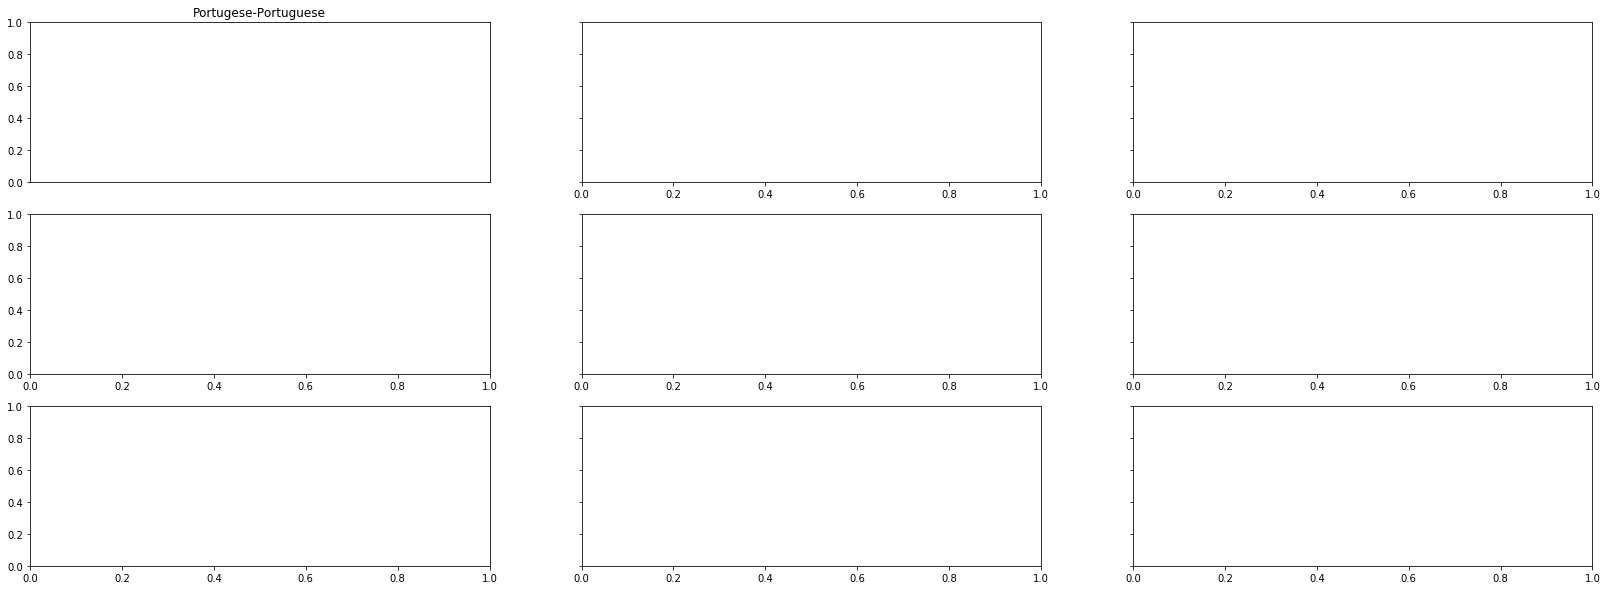

In [12]:
# Oxford spelling errors. Just a small database.
mistakes = pd.read_csv('Oxford_common_spellings.csv')
print(mistakes.head())


samp = mistakes.loc[[76, 31, 90, 14, 9, 6, 36, 91, 84]]

fig, ax = plt.subplots(3, 3, sharey=True)
fig.set_size_inches(28, 10, forward=True)
i = 0
j = 0
for row in samp.itertuples():
    ax[i][j].set_title(row.incorrect + '-' + row.correct)
    ax[i][j].xaxis.set_visible(False)


    vec = emb[w2id[row.incorrect]]-emb[w2id[row.correct]]
    ax[i][j].plot(vec)

    i += 1
    if i == 3:
        i = 0
        j += 1

/home/ssatti/miniconda2/envs/wvpy3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


17


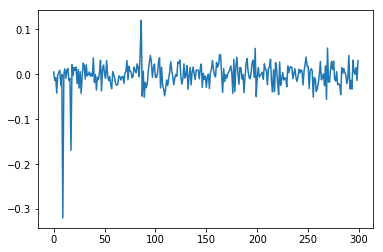

In [14]:
train, test = train_test_split(mistakes, train_size=0.85, random_state=42)
spell_transform = np.zeros((300,))
for row in train.itertuples():
    spell_transform += emb[w2id[row.incorrect]] - emb[w2id[row.correct]]
spell_transform /= len(train) #It is average of (incorrect - correct)

plt.plot(spell_transform)
print(len(test))

In [15]:
#transformation on the test set
test.loc[:, 'fixed'] = toWords(getNeighbours(test.incorrect, transform_vector=spell_transform, c=1), n=1)
print('{} correct out of {}'.format((test.fixed==test.correct).sum(), len(test)))
print('Accuracy on test set: {:.2f}%'.format((test.fixed==test.correct).sum()/len(test)*100.0))

8 correct out of 17
Accuracy on test set: 47.06%


/home/ssatti/miniconda2/envs/wvpy3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ssatti/miniconda2/envs/wvpy3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
# Push more in the direction of correct spellings using c=1.5
test.loc[:, 'fixed'] = toWords(getNeighbours(test.incorrect, transform_vector=spell_transform, c=1.5), n=1)
print('{} correct out of {}'.format((test.fixed==test.correct).sum(), len(test)))
print('Accuracy on test set: {:.2f}%'.format(1.0*(test.fixed==test.correct).sum()/len(test)*100))

16 correct out of 17
Accuracy on test set: 94.12%


/home/ssatti/miniconda2/envs/wvpy3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


      correct incorrect     fixed
18  chauffeur  chauffer  chauffer


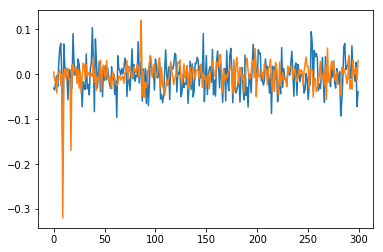

In [17]:
print(test[test.fixed!=test.correct])
# plt.plot(emb[w2id['Farenheit']]-emb[w2id['Fahrenheit']])
plt.plot(emb[w2id['chauffer']]-emb[w2id['chauffeur']])
plt.plot(spell_transform)

In [18]:
# Based on this block, we see that it's NOT plausible if edit distance is > 2.
mistakes['lev_score'] = mistakes.apply(lambda x: jellyfish.levenshtein_distance(x.correct, x.incorrect) / max(len(x.correct), len(x.incorrect)), axis=1)
mistakes['lev_distance'] = mistakes.apply(lambda x: jellyfish.levenshtein_distance(x.correct, x.incorrect), axis=1)
mistakes.sort_values('lev_distance').tail()

,correct,incorrect,lev_score,lev_distance
73,pharaoh,pharoah,0.285714,2
67,occasion,ocassion,0.250000,2
28,disappoint,dissapoint,0.200000,2
91,siege,seige,0.400000,2
46,guard,gaurd,0.400000,2


In [19]:
MAX_EDITS = 2 #We choose max edit distance as 2.

# Checks if word w2 is a plausible mistake of word w1. Uses edit distance along with some heuristics
def is_misspelling(w1, w2, max_edits=MAX_EDITS):
    # We want to focus on the spelling, and not the case of the letters, so we will lower case both words
    w1 = w1.lower()
    w2 = w2.lower()
    # First check that we don't just have a differently cased version of the same word
    if w1 != w2:
        # Next check that we aren't just creating a plural of of a singular word, or vica versa
        if not ((w1[-1] == 's' and w2[-1] != 's') or (w1[-1] != 's' and w2[-1] == 's')):
            # Next check that we haven't just stuck a 2 letter prefix or suffix on the word e.g. 'invent' ==> 'reinvent', 'invented'
            if not (w1[:-2] == w2 or w2[:-2] == w1 or w1[2:] == w2 or w2[2:] == w1):
                # Next, if the word ends in 'e', check we haven't just added a 'd'
                if not ((w1[-1] == 'e' and w2[-1] == 'd') or (w1[-1] == 'd' and w2[-1] == 'e')):
                    # Finally, if we passed all these tests, then calculate the Levenshtein distance
                    dist = jellyfish.levenshtein_distance(w1, w2)
                    return dist <= max_edits


In [20]:

scores = np.dot(emb[:20000], spell_transform)
sp = np.argsort(scores)
print ('The top 20 "best spelled" words:\n', ';  '.join([id2w[x] for x in sp[:50]]))
print()
print ('The top 20 "worst spelled" words:\n', ';  '.join([id2w[x] for x in sp[-50:]]))

The top 20 "best spelled" words:
 as;  which;  particularly;  whose;  that;  described;  addition;  significant;  noted;  While;  continues;  the;  suggests;  previously;  Although;  such;  present;  referred;  including;  particular;  continued;  both;  --;  often;  following;  whether;  among;  The;  remains;  followed;  their;  may;  however;  However;  latter;  considered;  known;  rather;  's;  follows;  while;  presence;  recent;  become;  As;  determined;  also;  identified;  several;  appears

The top 20 "worst spelled" words:
 Hobbyist;  FUCK;  Whats;  Lol;  =D;  ps3;  02088670410;  Hotel_Review;  permalinksaveparent;  cuz;  Logged;  ░;  ur;  vid;  ?????;  omg;  dat;  THANKS;  coz;  points1;  wasnt;  !!!!!!;  hes;  ;D;  ▒;  fuckin;  ppl;  theres;  soo;  Fav;  shes;  havent;  wouldnt;  teh;  ║;  aint;  ive;  ▄;  commentLoad;  goin;  luv;  pls;  ▀;  !!!!!!!;  wtf;  lmao;  wat;  !!!!!!!!;  plz;  awsome


In [21]:
emb_nonorm = np.zeros((50000, 300), dtype=np.float32) # # Search in un-normalized space!!

for cc, word in enumerate(list(glove.keys())[:50000]):
    emb_nonorm[cc] = glove[word]

scores = np.dot(emb_nonorm[:20000], spell_transform)
sp_nonorm = np.argsort(scores)
print ('The top 20 "best spelled" words:\n', ';  '.join([id2w[x] for x in sp_nonorm[:50]]))
print ('The top 20 "worst spelled" words:\n', ';  '.join([id2w[x] for x in sp_nonorm[-50:]]))

The top 20 "best spelled" words:
 U.S.;  officials;  political;  whose;  States;  significant;  percent;  among;  economic;  increasingly;  individuals;  often;  University;  such;  former;  efforts;  government;  York;  their;  particularly;  financial;  --;  organizations;  described;  students;  American;  institutions;  social;  Department;  began;  identified;  President;  federal;  which;  State;  presence;  may;  including;  noted;  his;  remains;  leadership;  United;  associated;  activities;  critical;  patients;  increased;  Washington;  individual
The top 20 "worst spelled" words:
 nigga;  LinkBack;  ;D;  EVINRUDE;  wouldnt;  !!!!!!;  vid;  havent;  LFS;  Fav;  FUCK;  THANKS;  Mercruiser;  omg;  Airbags;  ur;  points3;  :{;  hes;  ppl;  MouseWait;  ps3;  dat;  fuckin;  ░;  aint;  goin;  soo;  ive;  shes;  points1;  teh;  !!!!!!!;  luv;  wtf;  pls;  ▒;  lmao;  ▄;  pmPosts;  !!!!!!!!;  ▀;  wat;  ║;  agosorry;  fromServlet;  plz;  awsome;  commentLoad;  Hotel_Review


In [22]:
[id2w[x] for x in sp[10000:10050]]

['Arabic',
 'booth',
 'resistant',
 'Starbucks',
 'Want',
 'teens',
 'standpoint',
 'Golf',
 'arrests',
 'Document',
 '2014',
 'Laden',
 'Café',
 '127',
 'Cumberland',
 'Railway',
 'Me',
 'muscles',
 'Selected',
 'Jupiter',
 'ordinance',
 'Host',
 'Shadow',
 'noble',
 'climbed',
 'Physicians',
 'Girl',
 '3-D',
 'collector',
 'posture',
 'lightweight',
 'healthier',
 'Raleigh',
 'benchmark',
 'fiber',
 'Rangers',
 'souls',
 'tactic',
 'homeland',
 'Measures',
 'primitive',
 '1923',
 'Dog',
 'Alexandra',
 'Boone',
 'snapped',
 'utter',
 'Airlines',
 'Hal',
 'Contest']

In [23]:
pattern = re.compile('[\WA-Z0-9_]')
def checkword(wrd, minlen=3):
    # returns True if the wrd only contains the letters a-z
    return len(wrd) >= minlen and pattern.sub('', wrd) == wrd

training_list = [id2w[x] for x in sp[:15000] if checkword(id2w[x])]
print(len(training_list))

8977


In [24]:
%time I = getNeighbours(training_list, spell_transform, -1.5, neighbours=10)

CPU times: user 13min 15s, sys: 1min 14s, total: 14min 29s
Wall time: 36.4 s


In [26]:
pairs = []
for ls, wrd in zip(I, training_list):
    if wrd in test.correct:
        continue
    for misspell in ls:
        if checkword(id2w[misspell]) and id2w[misspell] not in training_list and is_misspelling(wrd, id2w[misspell]):
            pairs.append((wrd, id2w[misspell]))
print('Generate {} pairs'.format(len(pairs)))
print(pairs[1000:1025])

Generate 14157 pairs
[('whom', 'whome'), ('characterized', 'characterised'), ('they', 'thay'), ('social', 'socail'), ('social', 'soical'), ('social', 'socia'), ('social', 'socio'), ('traditional', 'traditonal'), ('traditional', 'tradional'), ('traditional', 'tradtional'), ('traditional', 'traditionnal'), ('traditional', 'traditiona'), ('current', 'curent'), ('current', 'currrent'), ('current', 'currect'), ('current', 'curret'), ('current', 'curretn'), ('current', 'cuurent'), ('current', 'currnt'), ('seemingly', 'seeminly'), ('common', 'commom'), ('common', 'comon'), ('common', 'comman'), ('maintain', 'mantain'), ('maintain', 'maintian')]


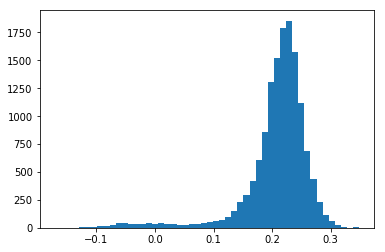

In [27]:
incorrects = [np.dot(emb[w2id[x[1]]], spell_transform) for x in pairs]
_ =plt.hist(incorrects, bins=50)

In [28]:
print([pairs[x] for x in np.argwhere(np.asarray(incorrects) < 0.1)[:, 0]])

pairs = [pairs[x] for x in np.argwhere(np.asarray(incorrects) > 0.1)[:, 0]]
print(len(pairs))

[('their', 'thier'), ('bringing', 'brining'), ('similar', 'similiar'), ('will', 'wil'), ('indicate', 'indicative'), ('successful', 'succesful'), ('his', 'hes'), ('role', 'rôle'), ('demonstrate', 'demonstrable'), ('focuses', 'focusses'), ('resulting', 'resultant'), ('focused', 'focussed'), ('received', 'recieved'), ('emphasis', 'emphases'), ('emphasis', 'emphasizes'), ('separate', 'seperate'), ('financial', 'ﬁnancial'), ('across', 'accross'), ('commitment', 'committment'), ('characterized', 'characterised'), ('social', 'socio'), ('activities', 'activites'), ('existence', 'existance'), ('practices', 'practises'), ('reflected', 'refracted'), ('initiated', 'instigated'), ('prepared', 'prepped'), ('affected', 'effected'), ('receive', 'recieve'), ('conclusion', 'conclusive'), ('focusing', 'focussing'), ('committed', 'commited'), ('employees', 'employes'), ('independent', 'independant'), ('consumers', 'costumers'), ('carrying', 'ferrying'), ('kind', 'kinda'), ('capital', 'capitol'), ('prepari

In [29]:

spell_transform_2 = np.zeros(300)
for p in pairs:
    spell_transform_2 += emb[w2id[p[1]]] - emb[w2id[p[0]]]
spell_transform_2 /= len(pairs)

[[1.         0.90281464]
 [0.90281464 1.        ]]
0.03035938989463681
0.044775369099204855


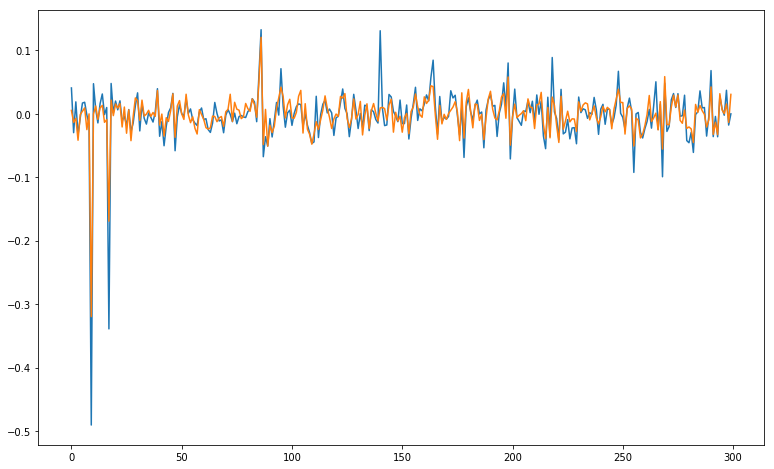

In [31]:

print(np.corrcoef(spell_transform, spell_transform_2))
print(np.std(spell_transform))
print(np.std(spell_transform_2))

plt.figure(figsize=(13,8))
plt.plot(spell_transform_2)
plt.plot(spell_transform)



In [32]:
test.loc[:, 'fixed'] = toWords(getNeighbours(test.incorrect, transform_vector=spell_transform_2, c=1.4), n=1)
print('Accuracy on test set: {:.2f}%'.format((test.fixed==test.correct).sum()/len(test)*100))

Accuracy on test set: 100.00%


In [33]:
train_pairs = pd.DataFrame(pairs, columns=['correct', 'incorrect'])
print(len(train_pairs))

train_pairs.loc[:, 'fixed'] = toWords(getNeighbours(train_pairs.incorrect, transform_vector=spell_transform_2, c=1.4), n=1)
print('Accuracy on train set: {:.2f}%'.format((train_pairs.fixed==train_pairs.correct).sum()/len(train_pairs)*100))

13502
Accuracy on train set: 89.71%


            correct     incorrect        fixed
13497  dial          dail          daily      
425    begun         begain        began      
10880  encyclopedia  uncyclopedia  Wikipedia  
12737  plasma        plazma        plazma     
9620   ice           icey          icy        
11917  mechanics     mecanics      fundamental
13461  gods          godess        goddess    
2877   below         belwo         above      
822    possibility   possibily     possibly   
9693   favorites     favorties     favorite   
9854   identifiable  identifiably  distinct   
11305  electronics   electronis    electronic 
9957   suffers       sufferes      suffer     
9815   archives      achives       through    
12084  fundamentals  fundaments    fundamental
11094  smile         smily         smiley     
10361  recognise     recongnize    recognize  
592    begin         begain        began      
3170   named         nammed        whose      
13082  eaten         eatten        being      


/home/ssatti/miniconda2/envs/wvpy3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


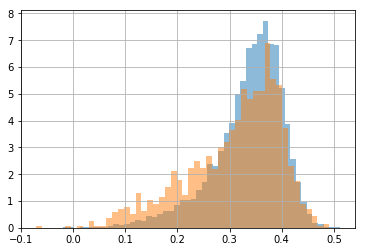

In [34]:
print(train_pairs[train_pairs.fixed!=train_pairs.correct].sample(20)) #To see what we missed.

train_pairs['score'] = train_pairs.incorrect.apply(lambda x: np.dot(emb[w2id[x]], spell_transform_2))
train_pairs[train_pairs.fixed==train_pairs.correct].score.hist(bins=50, normed=True, alpha=0.5)
train_pairs[train_pairs.fixed!=train_pairs.correct].score.hist(bins=50, normed=True, alpha=0.5)

In [35]:
train_pairs[(train_pairs.score < 0.15) & (train_pairs.fixed!=train_pairs.correct)].sort_values('score')

,correct,incorrect,fixed,score
3670,ever,ive,'ve,-0.071409
6003,gone,goin,going,-0.005023
13380,mad,lmao,lol,0.010468
5022,saying,sayin,say,0.030969
337,throughout,throught,through,0.033898
12857,thank,thanx,thanks,0.038877
5492,real,realy,really,0.039881
3642,belief,belive,believe,0.049938
11290,pack,pak,pak,0.058317
2834,little,alittle,bit,0.063642


In [36]:
print(toWords(getNeighbours(['absolutly'], transform_vector=spell_transform_2, c=1.4), n=5))
print(toWords(getNeighbours(['dreampt'], transform_vector=spell_transform_2, c=1.4), n=5))

[['absolutely', 'totally', 'truly', 'really', 'so']]
[['realized', 'dreamed', 'been', 'had', 'meant']]


In [37]:

def pickBest(candidates_list, word_list):
    best = []
    for candidates, word in zip(candidates_list, word_list):
        found = False
        for c in candidates:
            if c == word or is_misspelling(c, word):
                best.append(c)
                found=True
                break
        if not found:
            best.append(word) # #just add the original word
    return best

In [38]:

train_pairs['c'] = train_pairs.score.apply(lambda x: 1.2 + x * 1)

train_pairs.loc[:, 'fixed'] = pickBest(toWords(getNeighbours(train_pairs.incorrect, transform_vector=spell_transform_2, c=np.expand_dims(train_pairs['c'].values, 1)), n=5), train_pairs.incorrect)
print('Accuracy on train set: {:.2f}%'.format((train_pairs.fixed==train_pairs.correct).sum()/len(train_pairs)*100))


Accuracy on train set: 91.90%


In [39]:
from scipy.optimize import fmin

In [40]:
train_sample = train_pairs.sample(frac=0.1, random_state=1234)

def getErrorRate(params):
    train_sample['c'] = train_sample.score.apply(lambda x: params[0]+ x * params[1])
    train_sample.loc[:, 'fixed'] = pickBest(toWords(getNeighbours(train_sample.incorrect, transform_vector=spell_transform_2, c=np.expand_dims(train_sample['c'].values, 1)), n=5), train_sample.incorrect)
    print('Accuracy using params {} and {}: {:.2f}%'.format(params[0], params[1], (train_sample.fixed==train_sample.correct).sum()/len(train_sample)*100))
    return (train_sample.fixed!=train_sample.correct).sum()/len(train_sample)

In [41]:
params = fmin(getErrorRate, [1.2, 1.0],  xtol=0.01)

Accuracy using params 1.2 and 1.0: 92.30%
Accuracy using params 1.26 and 1.0: 91.33%
Accuracy using params 1.2 and 1.05: 91.93%
Accuracy using params 1.14 and 1.0499999999999998: 92.81%
Accuracy using params 1.0799999999999996 and 1.0749999999999997: 92.74%
Accuracy using params 1.14 and 0.9999999999999998: 92.89%
Accuracy using params 1.1099999999999999 and 0.9749999999999996: 92.96%
Accuracy using params 1.05 and 1.0249999999999995: 92.15%
Accuracy using params 1.1625 and 1.0062499999999999: 92.81%
Accuracy using params 1.0875 and 1.0187499999999996: 92.74%
Accuracy using params 1.14375 and 1.009375: 92.96%
Accuracy using params 1.1137500000000002 and 0.9343749999999997: 92.81%
Accuracy using params 1.1334374999999999 and 1.02109375: 92.89%
Accuracy using params 1.1203125000000003 and 0.9632812499999996: 93.11%
Accuracy using params 1.1137500000000005 and 0.9343749999999993: 92.81%
Accuracy using params 1.0865625 and 0.9289062499999994: 92.67%
Accuracy using params 1.129453125 and 0.

In [42]:
train_pairs['c'] = train_pairs.score.apply(lambda x: params[0] + x * params[1])
train_pairs.loc[:, 'fixed'] = pickBest(toWords(getNeighbours(train_pairs.incorrect, transform_vector=spell_transform_2, c=np.expand_dims(train_pairs['c'].values, 1)), n=5), train_pairs.incorrect)
print('Accuracy on train set: {:.2f}%'.format((train_pairs.fixed==train_pairs.correct).sum()/len(train_pairs)*100))

Accuracy on train set: 92.85%


In [43]:
train_pairs[train_pairs.fixed!=train_pairs.correct].sample(20) #Still not getting correct

,correct,incorrect,fixed,score,c
875,have,havnt,havent,0.130559,1.258609
8223,premier,premire,premiere,0.315572,1.441635
1791,added,addd,add,0.393051,1.518282
3412,headed,headin,heading,0.263724,1.390344
12552,tolerate,tolorate,tolorate,0.440402,1.565124
5243,employers,employess,employees,0.274034,1.400543
10052,elder,eldery,elderly,0.298148,1.424398
570,these,thoose,those,0.349835,1.475530
12434,crystal,cristal,cristal,0.213467,1.340627
12734,fantasies,fantasys,fantasys,0.320416,1.446428


In [44]:
allwords = [x for x in id2w if checkword(x, 3)]
print(len(allwords))
print(allwords[-20:])

418757
['trainiing', 'trompettes', 'tylerdurden', 'unaturally', 'uniao', 'upstretched', 'vakker', 'vampaneze', 'vinted', 'vocÃª', 'wiid', 'woombie', 'wordsforyoungmen', 'wried', 'wwent', 'xalisae', 'xtremecaffeine', 'yildirim', 'zipout', 'zulchzulu']


In [45]:
allwords = pd.DataFrame(allwords, columns=['original'])
allwords['score'] = allwords.original.apply(lambda x: np.dot(emb[w2id[x]], spell_transform))
allwords['c'] = allwords.score.apply(lambda x: params[0]+ x * params[1])

In [46]:
#
allwords['fixed'] = pickBest(toWords(getNeighbours(allwords.original, transform_vector=spell_transform_2, c=np.expand_dims(allwords['c'].values, 1)), n=5), allwords.original)

In [47]:
print(sum(allwords.fixed!=allwords.original))
print(allwords[allwords.fixed!=allwords.original].sample(50))

37106
            original     score         c        fixed
255371  plya          0.223334  1.350388  play       
212316  werld         0.250273  1.377038  world      
65470   earing        0.176451  1.304009  earring    
164260  behavious     0.250612  1.377373  behaviors  
156332  trialer       0.212011  1.339186  trailer    
271967  parot         0.228173  1.355175  parrot     
122199  pedistal      0.208187  1.335404  pedestal   
50485   mony          0.169903  1.297531  money      
81637   primative     0.204530  1.331786  primitive  
325785  citezen       0.214246  1.341398  citizen    
158893  introducted   0.195878  1.323227  introduced 
217802  cencus        0.205516  1.332762  census     
145145  permenent     0.219582  1.346676  permanent  
260247  gadets        0.222896  1.349955  gadgets    
163824  cirle         0.220331  1.347417  circle     
360566  structered    0.232667  1.359621  structured 
173819  parady        0.249252  1.376027  parody     
254796  safegaurd     

In [48]:
print(toWords(getNeighbours(['tennage'], transform_vector=spell_transform_2, c=1.32), n=5))
print(toWords(getNeighbours(['tennage'], transform_vector=spell_transform_2, c=1.4), n=5))

[['tennage', 'teenage', 'young', 'girls', 'boys']]
[['teenage', 'tennage', 'young', 'girls', 'individual']]


In [49]:
import pickle

spellingDict = {k:v for _, k,v in allwords.loc[allwords.fixed!=allwords.original, ['original', 'fixed']].itertuples()}
pickle.dump(spellingDict, open('spellingDict.pkl', 'wb'))
allwords.loc[allwords.fixed!=allwords.original, ['original', 'fixed']].to_csv('spelling_pairs.csv.gz', index=False, compression='gzip')

[[[1, 1], 1]]
[[[1, 2], 2]]
[[[1, 2], 2], [[7, 7], 1]]
[[[1, 2], 2], [[6, 7], 2]]
[[[1, 2], 2], [[4, 4], 1], [[6, 7], 2]]
[[[1, 3], 3], [[4, 4], 1], [[6, 7], 2]]
[[[1, 3], 3], [[4, 5], 2], [[6, 7], 2]]
